In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

In [85]:
def Data(l):
    data = pd.read_csv(l, delimiter=' ')
    return data

def Spectrum(datax,datay):
    marker_x = []
    marker_y = []
    index_y = []
    index_x = []
    anotaciones = []

    for i in range(0,len(datax)):
        mark = i

        if mark != 0 and mark != len(datax)-1:
            last = datay[mark - 1]
            next = datay[mark + 1]

            #Hallar máximos de espectro
            if (last < datay[i]) and (next < datay[i]) and (datay[i]>525) and (datax[i] != 187):
                marker_x.append(datax[i])
                marker_y.append(datay[i])

                index_y.append( datay[i-7:i+7] )
                index_x.append( datax[i-7:i+7] )

                anotaciones.append(str(datax[i]))
                
    return marker_x,marker_y,index_x,index_y,anotaciones

datos = Data(r"C:\Users\clauw\Documents\Programming\Torium-Operation\th 6200 orden 2 spec.txt")
pixel = np.array(datos['P'])
intensidad = np.array(datos['I'])
marker_x,marker_y, index_x,index_y,anotaciones = Spectrum(pixel,intensidad)

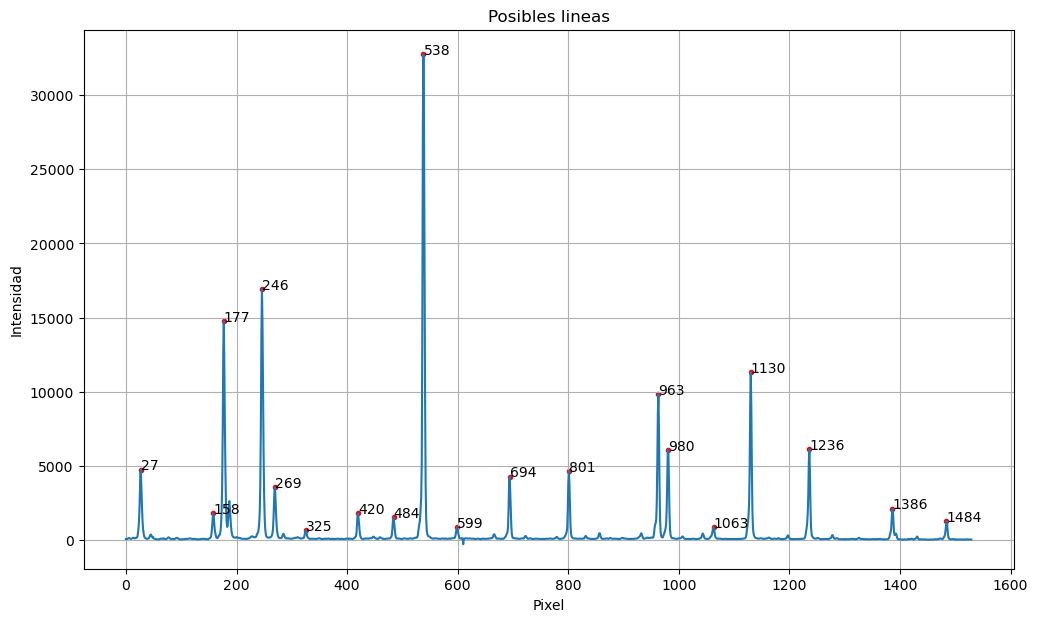

In [86]:
fig1, ax1 = plt.subplots(1,1, figsize=(12,7))
ax1.plot(pixel,intensidad)
ax1.scatter(marker_x,marker_y,marker='.',color = 'red')
ax1.set_title('Posibles lineas')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Intensidad')
ax1.grid()
for i, label in enumerate(anotaciones):
    plt.annotate(label, (marker_x[i] + 0.1, marker_y[i]))

# fig1.savefig('th 6200 orden 2 espectro tratado.jpg')

In [87]:
#Ajuste de Lorentz

def Lorentzian(x,h,x0,W):
    return h*W**2/((x-x0)**2+W**2)

def AjusteLorentz(i):
    x = index_x[i]
    y = index_y[i] 
    x_1 = np.linspace(x[0],x[-1],500 )

    popt, _ = curve_fit(Lorentzian,x,y) 
    h = popt[0]
    x0 = popt[1]
    w = popt[2]

    fit_y= Lorentzian(x_1,h,x0,w)

    return x0,h,fit_y,x_1, x, y

# plt.plot(fitx,fity, '--',color='b')
# plt.scatter(x,y)

Datafit = pd.DataFrame()
lineasfit = []
alturafit = []
catalog_long = [ 6164.48, 0, 6169.82, 6172.28, 6173.10, 0, 6178.43, 6180.71, 6182.62, 6184.78, 6188.13, 6191.91, 0, 6198.22, 0, 6203.49, 6207.22, 6212.51, 6215.95 ]


for i in range(0,19):
    linea,altura, fity, fitx, x, y = AjusteLorentz(i)
    lineasfit.append(linea)
    alturafit.append(altura)
    
Datafit['Pixel'] = lineasfit
Datafit['Instensidad'] = alturafit
Datafit['Catalogo longitud'] = catalog_long
Datafit.drop([1,5,12,14], axis=0, inplace=True)
Datafit

,Pixel,Instensidad,Catalogo longitud
0,26.739237,5001.843020,6164.48
2,177.003305,15353.197646,6169.82
3,246.166012,17790.369569,6172.28
4,269.326072,3712.917835,6173.10
6,419.733041,1940.658911,6178.43
7,483.937532,1615.436817,6180.71
8,538.155621,35320.176747,6182.62
9,598.895878,875.488612,6184.78
10,693.850607,4563.389153,6188.13
11,801.067003,4910.595476,6191.91


pixel     onda
246   - 6172.28
420   - 6178.43
538   - 6182.62
801   - 6191.91
980   - 6198.22
1130  - 6203.49
1235  - 6207.22

In [88]:
param = np.polyfit(Datafit['Pixel'],Datafit['Catalogo longitud'], 3)
_x = np.linspace(min(Datafit['Pixel']),max(Datafit['Pixel']),len(Datafit['Pixel']))
ym = _x*_x*_x*param[0] + _x*_x*param[1] + _x*param[2] + param[3]
res = []

for i in range(0,14):
    l = [1,5,12,14]
    if i not in l:
        ye = param[0]*Datafit['Pixel'][i]*Datafit['Pixel'][i]*Datafit['Pixel'][i] + param[1]*Datafit['Pixel'][i]*Datafit['Pixel'][i] + param[2]*Datafit['Pixel'][i] + param[3]
        res.append(ye-Datafit['Catalogo longitud'][i])

[ 7.46091234e-11 -3.31142308e-07  3.56506138e-02  6.16352333e+03]


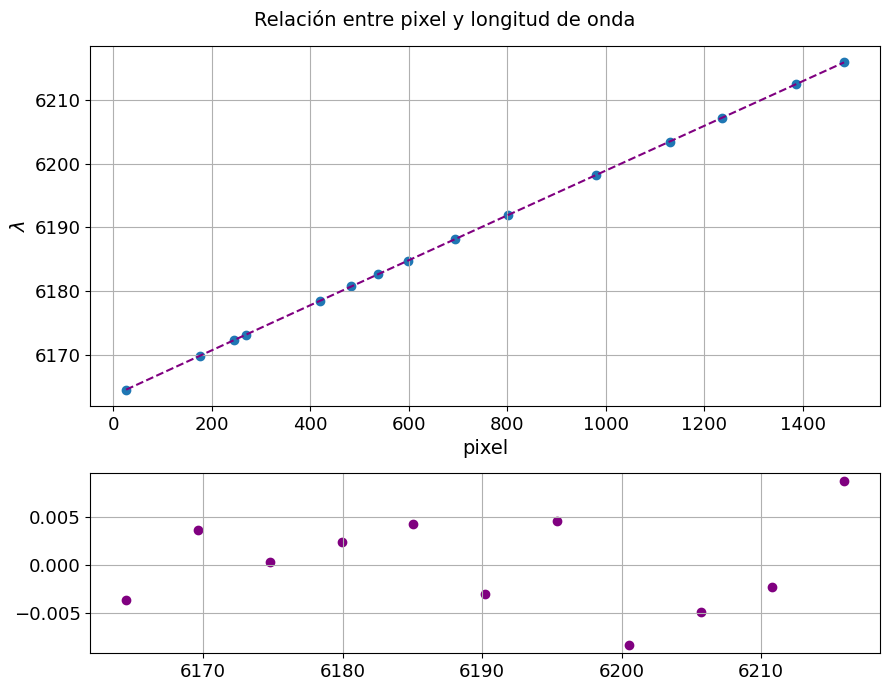

In [91]:
#Gráfico con residuos
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7), gridspec_kw = {"height_ratios":[2, 1]})
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Relación entre pixel y longitud de onda',fontsize=14)

ax1.scatter(Datafit['Pixel'],Datafit['Catalogo longitud'])
ax1.plot(_x,ym,'--',color='purple')
ax1.set_ylabel(r"$\lambda$",fontsize=14)
ax1.set_xlabel(r'pixel',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

xres = np.linspace(min(Datafit['Catalogo longitud']),max(Datafit['Catalogo longitud']),11)
ax2.scatter(xres,res,label = 'Residuos',color='purple')
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()
#plt.savefig('DvsV.pdf')
print(param)